In [55]:
from io import StringIO

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from numpy import NaN
from functions import * # import functions from the .py file

from pylab import rcParams
rcParams["figure.figsize"] = 16, 4

PAYLOADSIZE = 14

if PAYLOADSIZE % 2 != 0:
    print("Alarm! the payload size is not even.")
NUM_16RND = (PAYLOADSIZE-2)//2 # how many 16 bits random number included in each frame
MAX_SEQ = 256 # (decimal) maximum seq number defined by the length of the seq, the length of seq is 1B

## Log file

**For a fair comparison between groups, must follow the output format below**
<br>$\color{red}{\text{timestamp_rx }|\text{ len [hex] } \text{ seq [hex] } \text{ payload [hex] }|\text{rssi}}$
<br>$\text{ len [hex]}$ = payload length + 1 (seq. field length [1B])
<br>$\text{ payload [hex]}$ should start with the pseudo sequence number [2B], indicates the starting byte's position in the file.
***
*Example log file output for one frame with reciever timestamp xxxx, frame length, seq number and random payload, received signal strength.*
<br>15:17:18.394 |0f 46 bd f8 f7 ea 41 ac 1b be 05 a0 7f d2 09 d4 |  -91 CRC error
<br>$\color{red}{\text{delimiter for four variables is "|" and delimiter for the payload each byte is the space " ".}}$

In [56]:
# define the file name
filename = "logs/2023-03-29-11-24-00.txt"
# import file to jupyter notebook
df = readfile("./" + filename)
# check the imported data first 10 lines
df.head(10)

,index,time_rx,rssi,seq,payload
0,0,2023-03-29 00:36:33.497,-68,108,4d 10 21 85 34 bb 1d 50 15 e1 19 3b 1a 48
1,1,2023-03-29 00:36:33.561,-70,109,4d 1c 1a 33 29 4e 1b d4 1d a1 11 ac 28 76
2,2,2023-03-29 00:36:33.624,-69,110,4d 28 23 40 16 a3 31 c8 17 be 23 0b 23 10
3,3,2023-03-29 00:36:33.688,-70,111,4d 34 10 ef 20 ea 1f 25 22 81 19 57 1d 61
4,4,2023-03-29 00:36:33.752,-68,112,4d 40 2c 0d 29 1a 32 20 1f 62 19 62 16 7d
5,5,2023-03-29 00:36:33.816,-69,113,4d 4c 1c e9 2b 0b 28 4f 18 79 1c 94 12 10
6,6,2023-03-29 00:36:33.880,-69,114,4d 58 20 72 2a 0b 1b 44 23 0c 18 cb 18 44
7,7,2023-03-29 00:36:33.944,-69,115,4d 64 15 f2 21 99 21 0f 15 31 10 18 23 bd
8,8,2023-03-29 00:36:34.008,-69,116,4d 70 22 1d 17 4f 2c a0 23 52 16 35 21 44
9,9,2023-03-29 00:36:34.072,-69,117,4d 7c 38 0f 1b 83 1b ca 2a 1b 1a ec 2a 36


In [57]:
# delete the corrupted packets (PAYLOADSIZE + 2B pesudo sequence number)
df = df[df.payload.apply(lambda x: len(x)==((PAYLOADSIZE)*3-1))]
df.reset_index(inplace=True)

In [58]:
# replace the resettable seq number to unresettable, for the purpose of reliability calculation
test = replace_seq(df.copy(), MAX_SEQ=256)
test.rename(columns = {'seq':'old_seq', 'new_seq':'seq'}, inplace = True)

# Time

## Definition

**Evaluation metric**
<br>*File Transmission Time: the total latency that certain amount of Data $F$ is delivered to the destination.*
<br> $File\ Delay = Rx\_timestamp[N] - Rx\_timestamp[0]$
<br> where $N$ is the last packet
***
**Interesting to look at**:
<br>*Timestamp difference*: $\Delta T[i] = Rx\_timestamp[i] - Tx\_timestamp[i]$
1. *Worst-case packet delay*: the delay of the packet that takes the longest time to traverse.
2. *Packet delay variation*: the std of the packet delay.

In [59]:
# compute the file delay
file_delay = df.time_rx[len(df) - 1] - df.time_rx[0]
# convert the timedelta to s
file_delay_s = np.timedelta64(file_delay, "ms").astype(int) / 1000
print(f"The time it takes to transfer the file is : {file_delay}, which is {file_delay_s} seconds.")

The time it takes to transfer the file is : 0 days 00:01:02.082000, which is 62.082 seconds.


# Reliability

## Definition

**Evaluation metric**
<br>*Quality of data transfer.*
<br>*Bit Reliability*: The ratio of data bits correctly delivered to the data sink.
<br>*Bit Error Rate*: The ratio of data bits incorrectly delivered to the data sink.
$$Bit\ Reliability = 1 - BER = 1 - \frac{Number\ of\ wrong\ bit}{Total\ Number\ of\ bit\ sent}$$
***
**Interesting to look at**:
1. *Expected number of transmission*: the ratio of the number of packets correctly received by the data sink and the number of packets sent by the source.

$$ETX = \frac{Number\ of\ packet\ received}{Number\ of\ packet\ sent}$$

2. *Packet reliability*: the number of packet bit correctly delivered to next hop.

## Statistics

In [60]:
# compute the BER for all received packets
# return the in total ber for received file, error statistics and correct file content supposed to be transmitted
ber, error, file_content = compute_ber(test, PACKET_LEN=NUM_16RND*2, MAX_SEQ=MAX_SEQ)
bit_reliability = (1-ber)*100
print(f"Bit reliability [%]: {bit_reliability}")

The total number of packets transmitted by the tag is 1081.
Error statistics dataframe is:
      seq bit_error_tmp  bit_error
0     108          [43]         43
1     109          [27]         27
2     110          [33]         33
3     111          [33]         33
4     112          [41]         41
..    ...           ...        ...
968  1076          [42]         42
969  1077          [45]         45
970  1078          [44]         44
971  1079          [47]         47
972  1080          [39]         39

[973 rows x 3 columns]
Bit reliability [%]: 56.18041281260706


In [61]:
# payload example for debug purpose
# correct sequence for pesudoseq NO. '0000'
tmp = file_content.loc[int('0000', base=16), 'data']
for i in tmp:
    print("{:02x}".format(i), end=" ")

13 5d 1f 43 1b 45 25 6f 21 fe 0f 7e 

Text(0.5, 0, 'Seq. Number')

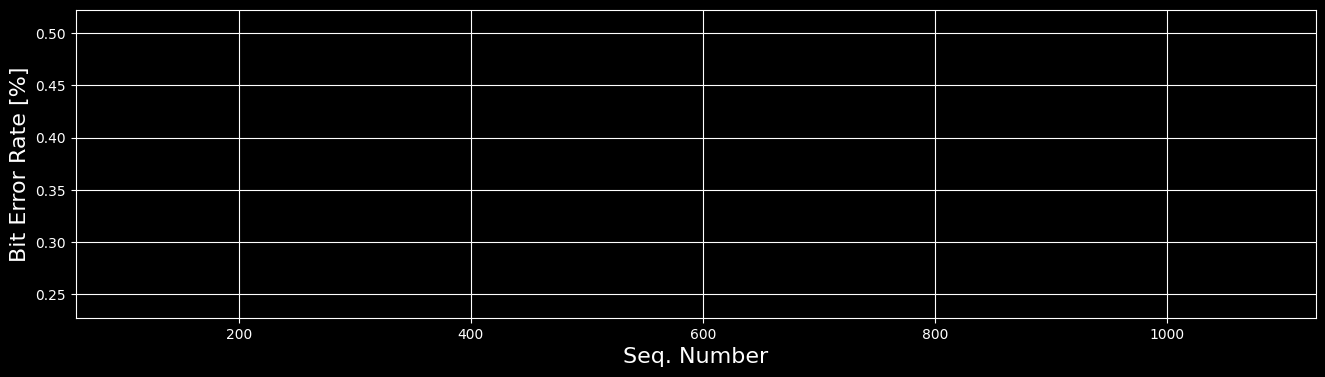

In [62]:
# BER for each packet
plt.scatter(error.seq, error.bit_error/(PAYLOADSIZE*8), marker='o', s=6, color='black')
plt.grid()
plt.ylabel('Bit Error Rate [%]', fontsize=16)
plt.xlabel('Seq. Number', fontsize=16)

# Distance

## Definition

**The communication distance of the system.**
<br>$D_{1}$: the distance between carrier<->backscatter_tag[m]
<br>$D_{2}$: the distance between backscatter_tag<->receiver[m]
<br> Distance metric = $D_{1}^2D_{2}^2$
<br>

In [63]:
# record the distance
dis_carrier_tag = 1
dis_tag_rx = 4

dis_metric = dis_carrier_tag**2*dis_tag_rx**2
print(f"Distance metric is: {dis_metric}")

Distance metric is: 16


# Radarplot

**Please pay attention to the unit**
<br> <font color='red'>Time</font>: use second as unit
<br> <font color='red'>Reliability</font>: use the percent as unit
<br> <font color='red'>Distance</font>: use meter as unit
<br>**Metics = [Time(s), Reliability(%), Distance(m)]**
<br> <font color='red'>Always keep the reference in your plot.</font>
<br> Tips: for ploting, time metric uses $\frac{1}{Time}*1000$ as the time metric, the higher the value the better the system performance

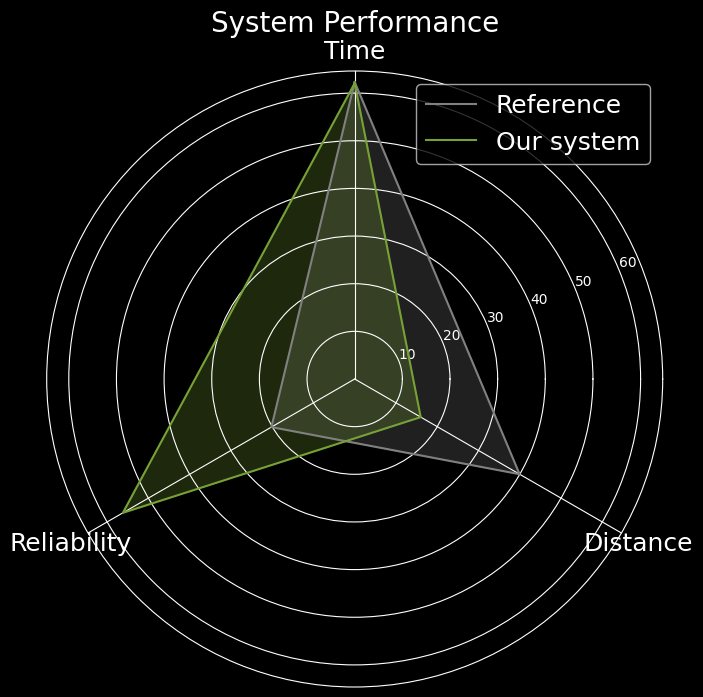

In [64]:
metrics = [file_delay_s, bit_reliability, dis_metric]
radar_plot(metrics)